# Setup & Import

In [43]:
import torch
import torch.nn as nn
import torchvision.models as models
from transformers import BertTokenizer, BertModel
import timm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Data Loading

In [44]:
# Define dataset paths (unchanged)
DATASET_ROOT_PATH = f'/kaggle/input/-visual-question-answering-computer-vision-nlp/dataset'
ANSWER_SPACE_PATH = f'/kaggle/input/visual-question-answering-computer-vision-nlp/dataset/answer_space.txt'
csv_path = f'/kaggle/input/visual-question-answering-computer-vision-nlp/dataset/data.csv'

# Verify and load the main CSV file
if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    print(f"Loaded dataset with {len(df)} entries.")
else:
    raise FileNotFoundError(f"{csv_path} not found. Run the dummy dataset creation code first.")

# Load answer space and create mappings
if os.path.exists(ANSWER_SPACE_PATH):
    with open(ANSWER_SPACE_PATH, 'r') as f:
        classes = f.read().split('\n')
        n_classes = len([cls for cls in classes if cls])  # Count non-empty lines
        classes_to_idx = {cls: idx for idx, cls in enumerate(classes) if cls}
        idx_to_classes = {idx: cls for idx, cls in enumerate(classes) if cls}
    print(f"Loaded {n_classes} unique answers.")
else:
    raise FileNotFoundError(f"{ANSWER_SPACE_PATH} not found. Run the dummy dataset creation code first.")

Loaded dataset with 12468 entries.
Loaded 582 unique answers.


# Exploratory Data Analysis & Visualization

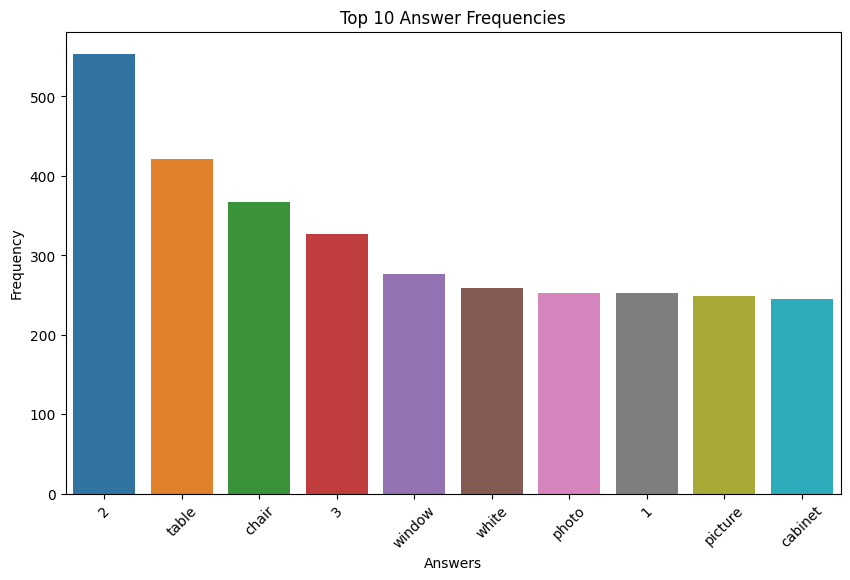

In [45]:
# Bar plot: Top 10 answer frequencies
answer_counts = df['answer'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=answer_counts.index[:10], y=answer_counts.values[:10])
plt.title('Top 10 Answer Frequencies')
plt.xlabel('Answers')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

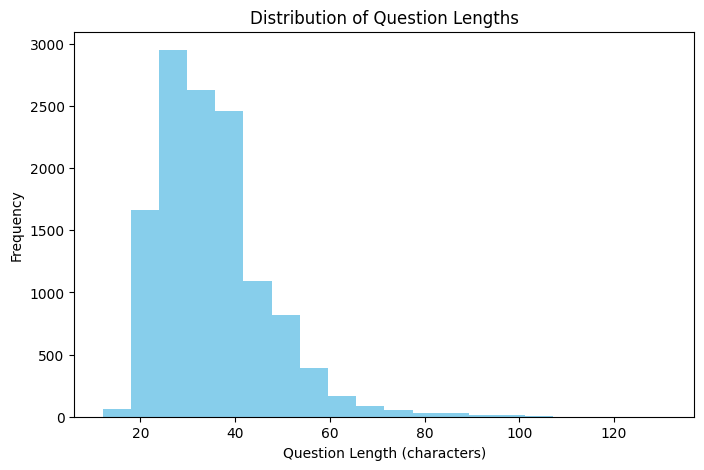

In [46]:
# Histogram: Question length distribution
df['question_length'] = df['question'].apply(len)
plt.figure(figsize=(8, 5))
plt.hist(df['question_length'], bins=20, color='skyblue')
plt.title('Distribution of Question Lengths')
plt.xlabel('Question Length (characters)')
plt.ylabel('Frequency')
plt.show()

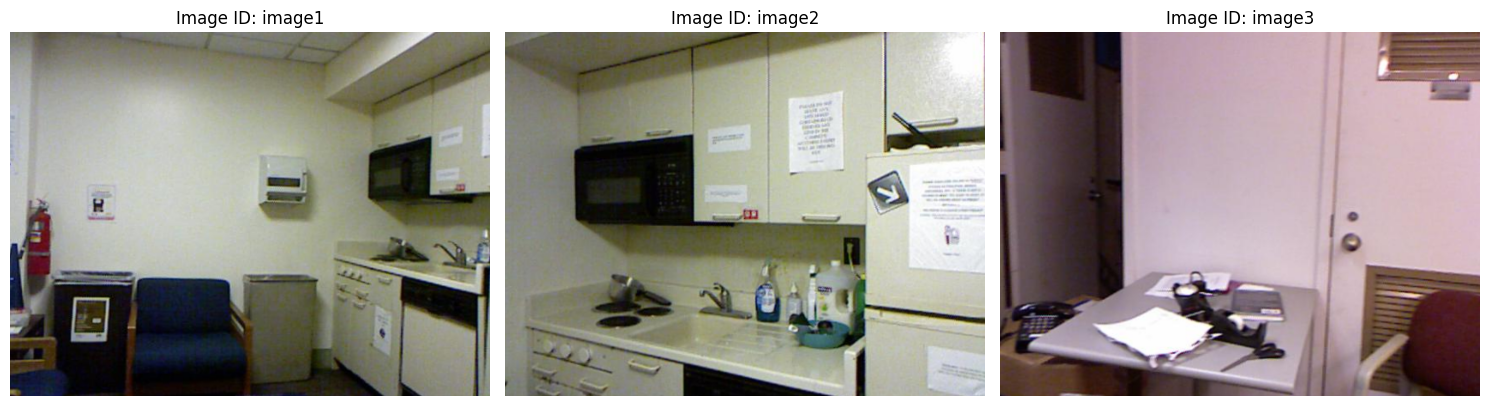

In [66]:
# Show sample images
sample_images = df['image_id'].unique()[:3]
plt.figure(figsize=(15, 5))
for i, img_id in enumerate(sample_images, 1):
    img_path = f'{DATASET_ROOT_PATH}/images/{img_id}.png'
    img = Image.open(img_path).convert('RGB')
    plt.subplot(1, 3, i)
    plt.imshow(img)
    plt.title(f'Image ID: {img_id}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Data Preprocessing

In [48]:
# Image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Text preprocessing
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
vocab_size = len(tokenizer.get_vocab())
max_seq_len = 30

def tokenize(question):
    return tokenizer.encode(
        question, add_special_tokens=True, max_length=max_seq_len,
        padding='max_length', truncation=True
    )

print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 30522


# Feature Engineering

In [49]:
# Load BERT model for text features (optional, can use simple token IDs instead)
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)
bert_model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [50]:
# Initialize vision models
resnet50 = models.resnet50(weights='ResNet50_Weights.IMAGENET1K_V1')
resnet50.fc = nn.Identity()
resnet50 = resnet50.to(device)

effnet = timm.create_model('efficientnet_b3', pretrained=True, num_classes=0)
effnet = effnet.to(device)

vit = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=0)
vit = vit.to(device)

vision_models = {
    'ResNet-50': (resnet50, 2048),
    'EfficientNet-B3': (effnet, 1536),
    'ViT-B/16': (vit, 768)
}

In [51]:
# Feature extraction functions
def extract_image_features(image, vision_model, feature_dim):
    vision_model.eval()
    with torch.no_grad():
        features = vision_model(image.unsqueeze(0).to(device))
        if features.dim() > 2:  # Handle ViT or spatial features
            features = features[:, 0] if 'vit' in str(type(vision_model)).lower() else features.mean(dim=(2, 3))
        return features.squeeze(0)

def extract_text_features(question, use_bert=True):
    tokens = tokenize(question)
    if use_bert:
        input_ids = torch.tensor(tokens).unsqueeze(0).to(device)
        with torch.no_grad():
            outputs = bert_model(input_ids)
            return outputs.last_hidden_state.mean(dim=1).squeeze(0)  # 768-dim
    return torch.tensor(tokens, dtype=torch.long).to(device)  # Token IDs

In [74]:
# Test feature extraction
sample_img = transform(Image.open(f'/kaggle/input/visual-question-answering-computer-vision-nlp/dataset/images/image1.png').convert('RGB'))
sample_question = "What is on the left side of the white oven?"
for name, (model, dim) in vision_models.items():
    img_features = extract_image_features(sample_img, model, dim)
    print(f"{name} image features shape: {img_features.shape}")
text_features = extract_text_features(sample_question, use_bert=True)
print(f"Text features shape: {text_features.shape}")

ResNet-50 image features shape: torch.Size([2048])
EfficientNet-B3 image features shape: torch.Size([1536])
ViT-B/16 image features shape: torch.Size([768])
Text features shape: torch.Size([768])


# Data Splitting

In [75]:
# Create data samples
def create_data_sample(df):
    return [{'question': q, 'answer': a.split(', ')[0], 'image_id': i}
            for q, a, i in zip(df['question'], df['answer'], df['image_id'])]

all_data = create_data_sample(df)
train_data, test_data = train_test_split(all_data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

# Dataset class
class VQADataset(Dataset):
    def __init__(self, data, classes_to_idx, transform, vision_model, feature_dim, root_dir, use_bert=True):
        self.data = data
        self.classes_to_idx = classes_to_idx
        self.transform = transform
        self.vision_model = vision_model
        self.feature_dim = feature_dim
        self.root_dir = root_dir
        self.use_bert = use_bert

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.data[idx]['image_id'] + '.png')
        img = Image.open(img_path).convert('RGB')
        img_features = extract_image_features(self.transform(img), self.vision_model, self.feature_dim)
        text_features = extract_text_features(self.data[idx]['question'], self.use_bert)
        answer = torch.tensor(self.classes_to_idx[self.data[idx]['answer']], dtype=torch.long).to(device)
        return img_features, text_features, answer

# Create datasets and loaders
train_loaders, val_loaders, test_loaders = {}, {}, {}
for name, (model, feature_dim) in vision_models.items():
    train_dataset = VQADataset(train_data, classes_to_idx, transform, model, feature_dim, f'{DATASET_ROOT_PATH}/images')
    val_dataset = VQADataset(val_data, classes_to_idx, transform, model, feature_dim, f'{DATASET_ROOT_PATH}/images')
    test_dataset = VQADataset(test_data, classes_to_idx, transform, model, feature_dim, f'{DATASET_ROOT_PATH}/images')
    
    train_loaders[name] = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loaders[name] = DataLoader(val_dataset, batch_size=16, shuffle=False)
    test_loaders[name] = DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f"Train size: {len(train_data)}, Val size: {len(val_data)}, Test size: {len(test_data)}")

Train size: 8976, Val size: 998, Test size: 2494


# Model Defining

In [76]:
class VQAModel(nn.Module):
    def __init__(self, feature_dim, num_classes, hidden_dim=512):
        super(VQAModel, self).__init__()
        self.text_proj = nn.Linear(768, hidden_dim)  # BERT output is 768-dim
        self.fusion = nn.Sequential(
            nn.Linear(feature_dim + hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.classifier = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, img_features, text_features):
        text_features = self.text_proj(text_features)
        fused_features = torch.cat([img_features, text_features], dim=1)
        fused_features = self.fusion(fused_features)
        logits = self.classifier(fused_features)
        return logits

# Initialize models
models = {
    'ResNet-50': VQAModel(2048, n_classes).to(device),
    'EfficientNet-B3': VQAModel(1536, n_classes).to(device),
    'ViT-B/16': VQAModel(768, n_classes).to(device)
}

# Model Configuration

In [77]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizers
optimizers = {
    'ResNet-50': torch.optim.Adam(models['ResNet-50'].parameters(), lr=1e-4),
    'EfficientNet-B3': torch.optim.Adam(models['EfficientNet-B3'].parameters(), lr=1e-4),
    'ViT-B/16': torch.optim.Adam(models['ViT-B/16'].parameters(), lr=1e-4)
}

print("Models configured with Adam optimizer and CrossEntropyLoss.")

Models configured with Adam optimizer and CrossEntropyLoss.


# Model Training (with Fine Tuning)

In [78]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for img_features, text_features, answers in train_loader:
            img_features, text_features, answers = img_features.to(device), text_features.to(device), answers.to(device)
            optimizer.zero_grad()
            outputs = model(img_features, text_features)
            loss = criterion(outputs, answers)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += answers.size(0)
            correct += (predicted == answers).sum().item()
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for img_features, text_features, answers in val_loader:
                img_features, text_features, answers = img_features.to(device), text_features.to(device), answers.to(device)
                outputs = model(img_features, text_features)
                loss = criterion(outputs, answers)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += answers.size(0)
                val_correct += (predicted == answers).sum().item()
        val_loss = val_loss / len(val_loader)
        val_acc = 100 * val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    return train_losses, val_losses, train_accs, val_accs

# Train all models
history = {}
for name in models:
    print(f"\nTraining {name}...")
    history[name] = train_model(models[name], train_loaders[name], val_loaders[name], criterion, optimizers[name])


Training ResNet-50...
Epoch [1/10] - Train Loss: 5.1465, Train Acc: 4.71%, Val Loss: 4.6751, Val Acc: 9.72%
Epoch [2/10] - Train Loss: 4.6373, Train Acc: 8.99%, Val Loss: 4.3708, Val Acc: 14.13%
Epoch [3/10] - Train Loss: 4.3330, Train Acc: 12.40%, Val Loss: 4.1543, Val Acc: 14.73%
Epoch [4/10] - Train Loss: 4.1188, Train Acc: 13.98%, Val Loss: 4.0004, Val Acc: 16.43%
Epoch [5/10] - Train Loss: 3.9686, Train Acc: 15.24%, Val Loss: 3.9096, Val Acc: 18.54%
Epoch [6/10] - Train Loss: 3.8512, Train Acc: 16.40%, Val Loss: 3.8152, Val Acc: 20.04%
Epoch [7/10] - Train Loss: 3.7452, Train Acc: 17.87%, Val Loss: 3.7936, Val Acc: 18.44%
Epoch [8/10] - Train Loss: 3.6486, Train Acc: 19.24%, Val Loss: 3.7224, Val Acc: 20.24%
Epoch [9/10] - Train Loss: 3.5572, Train Acc: 20.31%, Val Loss: 3.6792, Val Acc: 21.34%
Epoch [10/10] - Train Loss: 3.4915, Train Acc: 20.88%, Val Loss: 3.6480, Val Acc: 21.64%

Training EfficientNet-B3...
Epoch [1/10] - Train Loss: 5.0871, Train Acc: 5.27%, Val Loss: 4.5968,

# Training-Validation Accuracy & Loss Curve

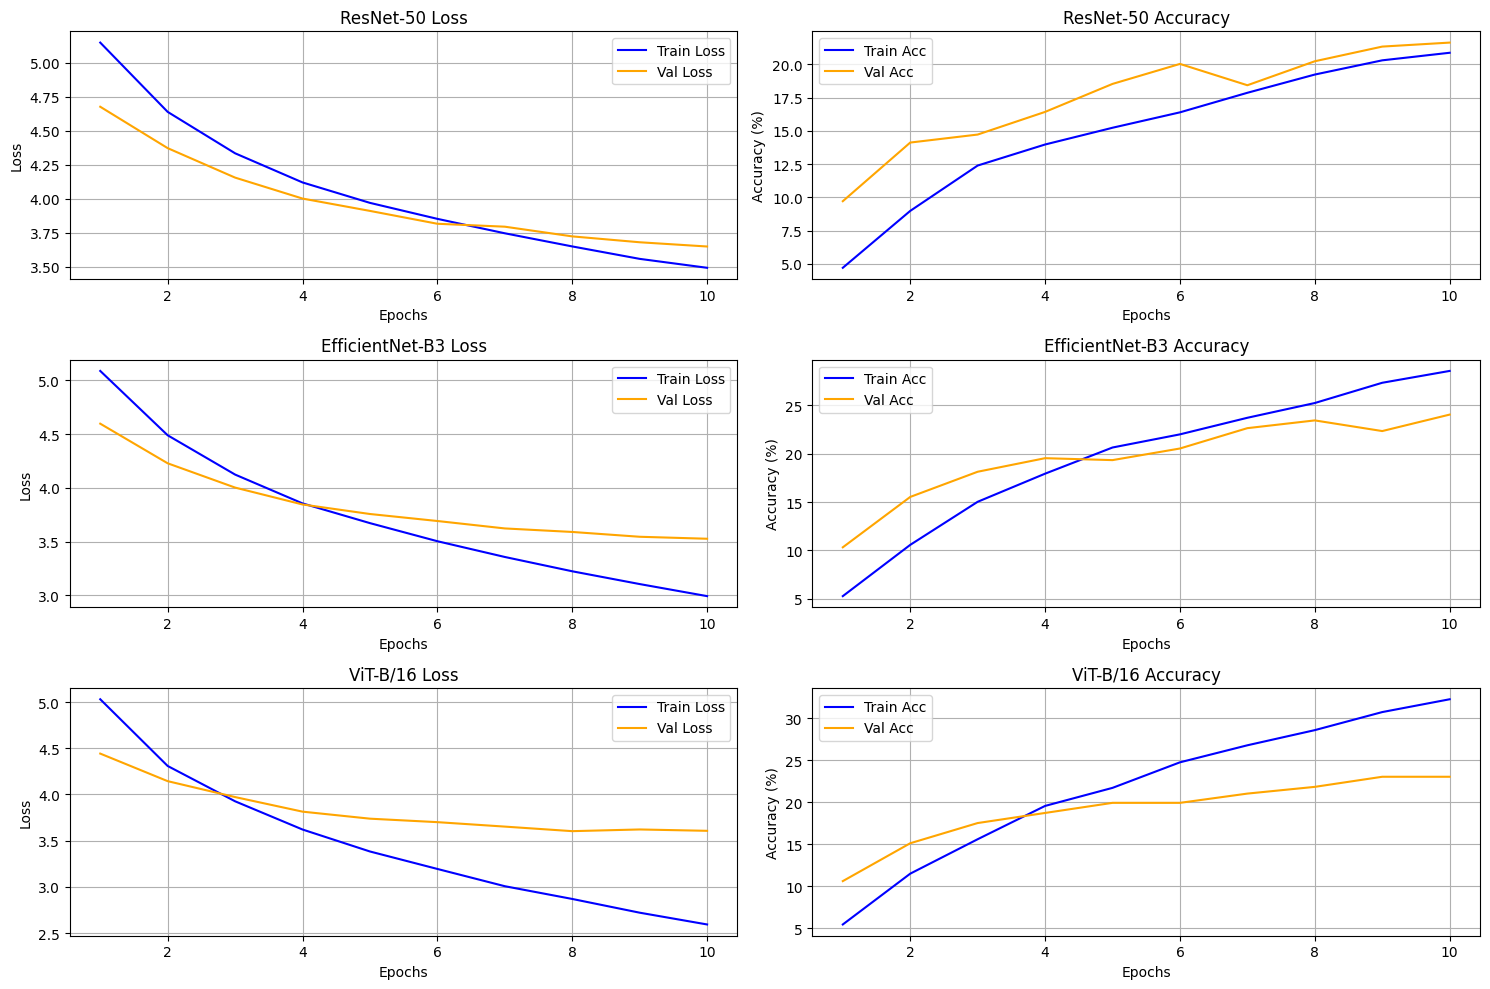

In [79]:
plt.figure(figsize=(15, 10))
for i, (name, (train_losses, val_losses, train_accs, val_accs)) in enumerate(history.items(), 1):
    epochs = range(1, len(train_losses) + 1)
    plt.subplot(3, 2, i*2-1)
    plt.plot(epochs, train_losses, label='Train Loss', color='blue')
    plt.plot(epochs, val_losses, label='Val Loss', color='orange')
    plt.title(f'{name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(3, 2, i*2)
    plt.plot(epochs, train_accs, label='Train Acc', color='blue')
    plt.plot(epochs, val_accs, label='Val Acc', color='orange')
    plt.title(f'{name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

# Model Evaluation


Evaluating ResNet-50...


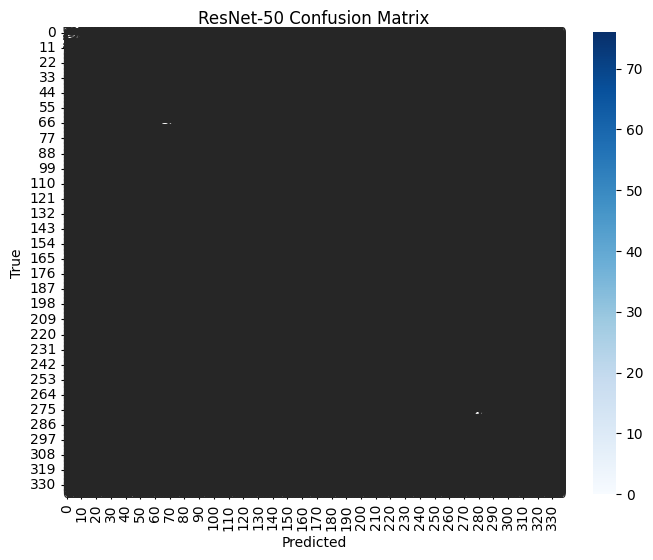

ResNet-50 Classification Report:
                            precision    recall  f1-score   support

                         1       0.31      0.08      0.12        64
                        10       0.00      0.00      0.00         6
                        11       0.00      0.00      0.00         3
                        12       0.00      0.00      0.00         1
                        13       0.00      0.00      0.00         1
                        14       0.00      0.00      0.00         1
                         2       0.32      0.68      0.43       112
                         3       0.12      0.19      0.15        70
                         4       0.06      0.04      0.05        49
                         5       0.00      0.00      0.00        17
                         6       0.00      0.00      0.00        20
                         7       0.00      0.00      0.00         9
                         8       0.00      0.00      0.00        10
              

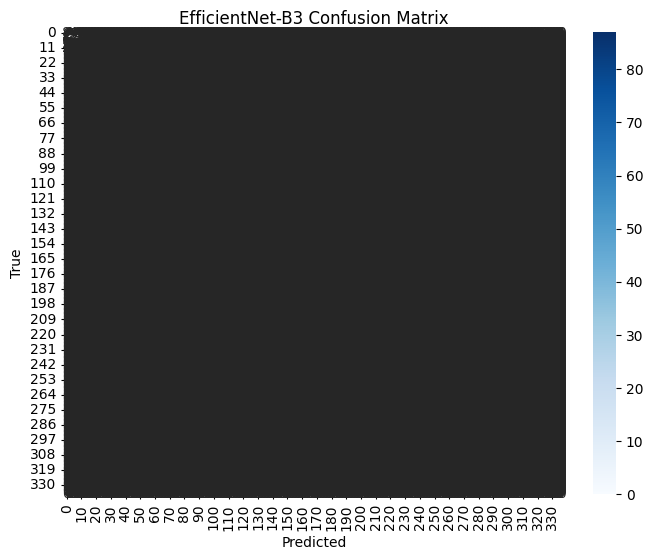

EfficientNet-B3 Classification Report:
                            precision    recall  f1-score   support

                         1       0.31      0.12      0.18        64
                        10       0.00      0.00      0.00         6
                        11       0.00      0.00      0.00         3
                        12       0.00      0.00      0.00         1
                        13       0.00      0.00      0.00         1
                        14       0.00      0.00      0.00         1
                         2       0.36      0.78      0.49       112
                         3       0.21      0.29      0.24        70
                         4       0.00      0.00      0.00        49
                         5       0.00      0.00      0.00        17
                         6       1.00      0.15      0.26        20
                         7       0.00      0.00      0.00         9
                         8       0.00      0.00      0.00        10
        

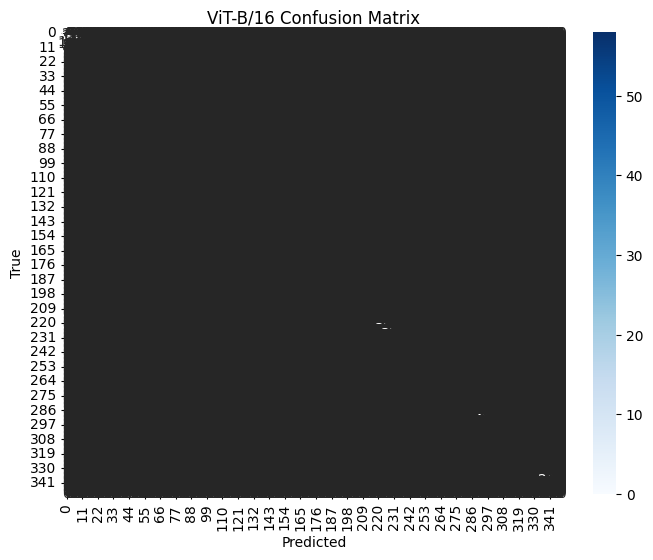

ViT-B/16 Classification Report:
                            precision    recall  f1-score   support

                         1       0.29      0.44      0.35        64
                        10       0.50      0.17      0.25         6
                        11       0.00      0.00      0.00         3
                        12       0.00      0.00      0.00         1
                        13       0.00      0.00      0.00         1
                        14       0.00      0.00      0.00         1
                         2       0.37      0.52      0.43       112
                         3       0.27      0.24      0.25        70
                         4       0.09      0.06      0.07        49
                         5       0.33      0.12      0.17        17
                         6       0.25      0.05      0.08        20
                         7       0.00      0.00      0.00         9
                         8       0.33      0.10      0.15        10
               

In [85]:
import warnings
warnings.filterwarnings('ignore')  # Suppress all warnings

from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import torch

def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for img_features, text_features, answers in test_loader:
            img_features, text_features, answers = img_features.to(device), text_features.to(device), answers.to(device)
            outputs = model(img_features, text_features)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(answers.cpu().numpy())
    
    # Get unique classes present in the test data
    unique_classes = sorted(set(all_labels + all_preds))
    target_names = [idx_to_classes[i] for i in unique_classes if i in idx_to_classes]
    
    # Compute confusion matrix and classification report with only the classes present
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, labels=unique_classes, target_names=target_names, output_dict=True)
    
    return cm, report, all_preds, all_labels

evaluations = {}
for name in models:
    print(f"\nEvaluating {name}...")
    cm, report, preds, labels = evaluate_model(models[name], test_loaders[name])
    evaluations[name] = (cm, report)
    
    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # Print Classification Report
    print(f"{name} Classification Report:")
    unique_classes = sorted(set(labels + preds))
    target_names = [idx_to_classes[i] for i in unique_classes]
    print(classification_report(labels, preds, labels=unique_classes, target_names=target_names))

# Re-enable warnings if needed later (optional)
warnings.filterwarnings('default')

# Model Comparison

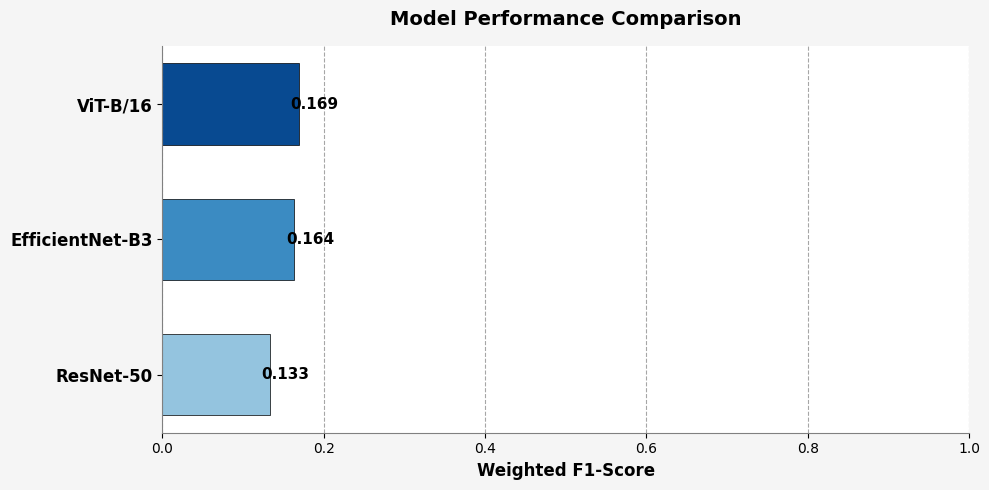

In [87]:
import warnings
warnings.filterwarnings('ignore')  # Suppress all warnings

import matplotlib.pyplot as plt
import numpy as np

# Extract weighted F1-scores from evaluations
test_f1_scores = {name: evaluations[name][1]['weighted avg']['f1-score'] for name in models}

# Define model names and scores
model_names = list(test_f1_scores.keys())
scores = list(test_f1_scores.values())

# Create a figure with a modern style
plt.figure(figsize=(10, 5), facecolor='#f5f5f5')  # Light gray background
ax = plt.gca()
ax.set_facecolor('#ffffff')  # White plot background

# Use a gradient color scheme (blue shades)
colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(model_names)))

# Plot horizontal bars with enhanced styling
bars = plt.barh(model_names, scores, color=colors, height=0.6, edgecolor='black', linewidth=0.5)

# Customize the plot
plt.xlabel('Weighted F1-Score', fontsize=12, weight='bold')
plt.title('Model Performance Comparison', fontsize=14, weight='bold', pad=15)
plt.xlim(0, 1)  # F1-score range

# Add gridlines for better readability (only x-axis)
plt.grid(True, axis='x', linestyle='--', alpha=0.7, color='gray')
plt.grid(False, axis='y')  # Remove y-axis gridlines

# Style the axes
ax.spines['top'].set_visible(False)  # Remove top spine
ax.spines['right'].set_visible(False)  # Remove right spine
ax.spines['left'].set_color('gray')  # Light gray left spine
ax.spines['bottom'].set_color('gray')  # Light gray bottom spine
plt.yticks(fontsize=12, weight='semibold')  # Model names on y-axis
plt.xticks(fontsize=10)

# Add data labels on the bars with slight offset
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.02, bar.get_y() + bar.get_height()/2, f'{width:.3f}', 
             ha='center', va='center', fontsize=11, weight='bold', color='black')

# Adjust layout for a clean look
plt.tight_layout()

# Display the plot
plt.show()

# Re-enable warnings if needed later (optional)
warnings.filterwarnings('default')

# Model Selection and Saving

In [89]:
# Step 13: Model Selection and Saving
import warnings
warnings.filterwarnings('ignore')  # Suppress all warnings

import torch
import os

# Select the best model based on weighted F1-score
best_model_name = max(test_f1_scores, key=test_f1_scores.get)
best_model = models[best_model_name]
print(f"Best model: {best_model_name} with Weighted F1-Score: {test_f1_scores[best_model_name]:.3f}")

# Replace '/' with '_' in the model name to avoid directory issues
safe_model_name = best_model_name.replace('/', '_')
model_save_path = f'{safe_model_name}_best_model.pth'

# Save the model weights
try:
    torch.save(best_model.state_dict(), model_save_path)
    print(f"Saved best model weights to {model_save_path}")
except Exception as e:
    print(f"Error saving model: {e}")
    # Optionally create a directory and retry
    os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
    torch.save(best_model.state_dict(), model_save_path)
    print(f"Retried and saved to {model_save_path} after creating directory")

warnings.filterwarnings('default')  # Reset warnings if needed

Best model: ViT-B/16 with Weighted F1-Score: 0.169
Saved best model weights to ViT-B_16_best_model.pth


# Inference/Prediction on New Data

In [92]:
# Step 14: Inference/Prediction
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings for clean output

import torch
from PIL import Image
from torchvision import transforms
import os

# Assuming these are defined from previous steps
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATASET_ROOT_PATH = '/kaggle/input/visual-question-answering-computer-vision-nlp/dataset'

# Load the saved model
best_model_name = 'ViT-B_16'  # From Step 13
model_save_path = f'{best_model_name}_best_model.pth'
best_model = VQAModel(vision_models[best_model_name.replace('_', '/')][1], n_classes).to(device)
best_model.load_state_dict(torch.load(model_save_path))
best_model.eval()
print(f"Loaded {best_model_name} from {model_save_path}")

# Define inference function
def predict_vqa(image_path, question, model, transform, tokenizer, vision_model, feature_dim, device):
    model.eval()
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image not found at {image_path}")
    img = Image.open(image_path).convert('RGB')
    img_features = extract_image_features(transform(img), vision_model, feature_dim).unsqueeze(0).to(device)
    text_features = extract_text_features(question, use_bert=True).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(img_features, text_features)
        _, predicted = torch.max(outputs, 1)
    return idx_to_classes[predicted.item()]

# Debug: List available images and pick a valid one
image_dir = f'{DATASET_ROOT_PATH}/images'
available_images = os.listdir(image_dir)
print(f"Available images (first 5): {available_images[:5]}")

# Example usage with a valid image
sample_image_id = available_images[0].replace('.png', '')  # Take first image, strip extension
sample_image = f'{image_dir}/{available_images[0]}'  # Use full file name
sample_question = "What is in the image?"

try:
    prediction = predict_vqa(
        sample_image,
        sample_question,
        best_model,
        transform,  # From Step 4
        tokenizer,  # From Step 4
        vision_models[best_model_name.replace('_', '/')][0],  # Vision model from Step 5
        vision_models[best_model_name.replace('_', '/')][1],  # Feature dim from Step 5
        device
    )
    print(f"Question: {sample_question}")
    print(f"Predicted answer: {prediction}")
except FileNotFoundError as e:
    print(e)

warnings.filterwarnings('default')  # Reset warnings

Loaded ViT-B_16 from ViT-B_16_best_model.pth
Available images (first 5): ['image1317.png', 'image1268.png', 'image745.png', 'image883.png', 'image869.png']
Question: What is in the image?
Predicted answer: television


# Hyperparameter Tuning

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Image directory: /kaggle/input/visual-question-answering-computer-vision-nlp/dataset/images, first 5 images: ['image1317.png', 'image1268.png', 'image745.png', 'image883.png', 'image869.png']

Tuning ViT-B_16 with lr=1e-05, batch_size=8
Epoch [1/3] - Train Loss: 5.7243, Train Acc: 2.33%, Val Loss: 4.9231, Val Acc: 5.61%
Epoch [2/3] - Train Loss: 4.9983, Train Acc: 4.22%, Val Loss: 4.7650, Val Acc: 6.51%
Epoch [3/3] - Train Loss: 4.8298, Train Acc: 5.49%, Val Loss: 4.6704, Val Acc: 8.02%
Test Weighted F1-Score: 0.031

Tuning ViT-B_16 with lr=1e-05, batch_size=16
Epoch [1/3] - Train Loss: 5.9629, Train Acc: 2.48%, Val Loss: 5.2465, Val Acc: 5.41%
Epoch [2/3] - Train Loss: 5.1529, Train Acc: 4.32%, Val Loss: 4.8946, Val Acc: 5.81%
Epoch [3/3] - Train Loss: 4.9809, Train Acc: 4.48%, Val Loss: 4.7882, Val Acc: 6.01%
Test Weighted F1-Score: 0.023

Tuning ViT-B_16 with lr=0.0001, batch_size=8
Epoch [1/3] - Train Loss: 4.9533, Train Acc: 6.12%, Val Loss: 4.3684, Val Acc: 13.33%
Epoch [2/3] - T

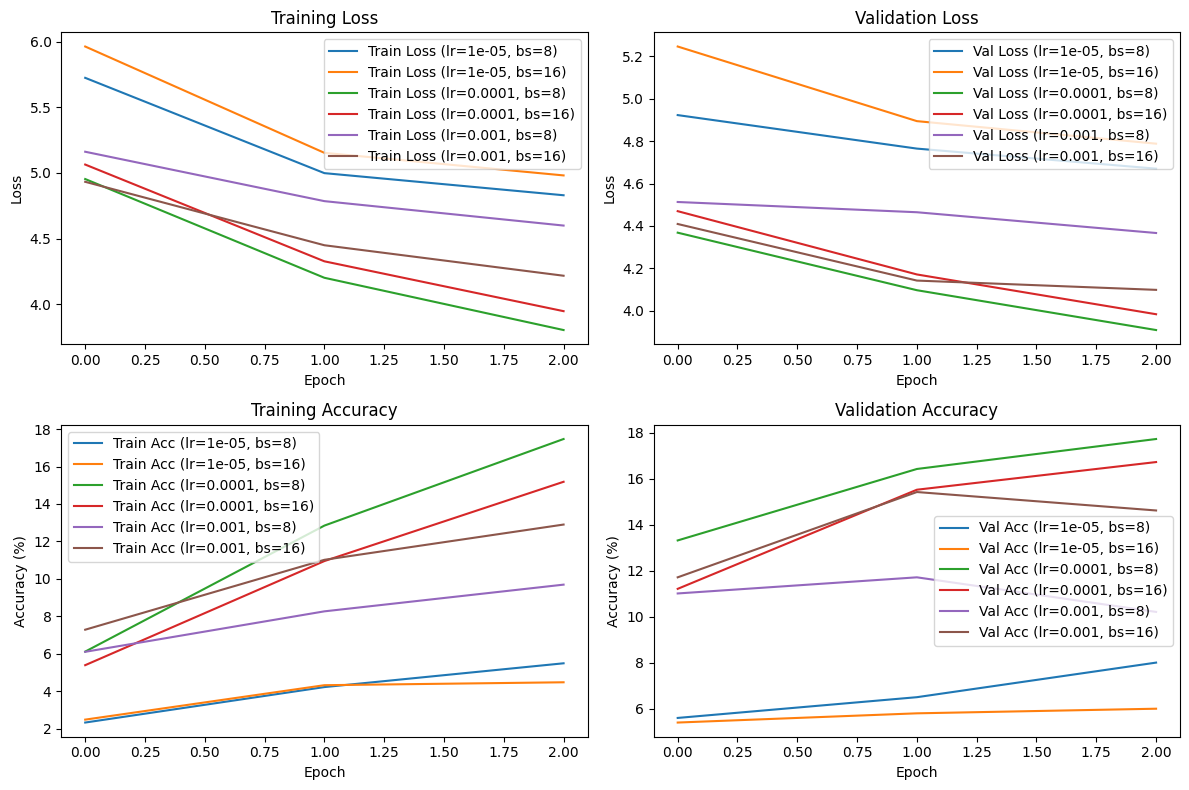

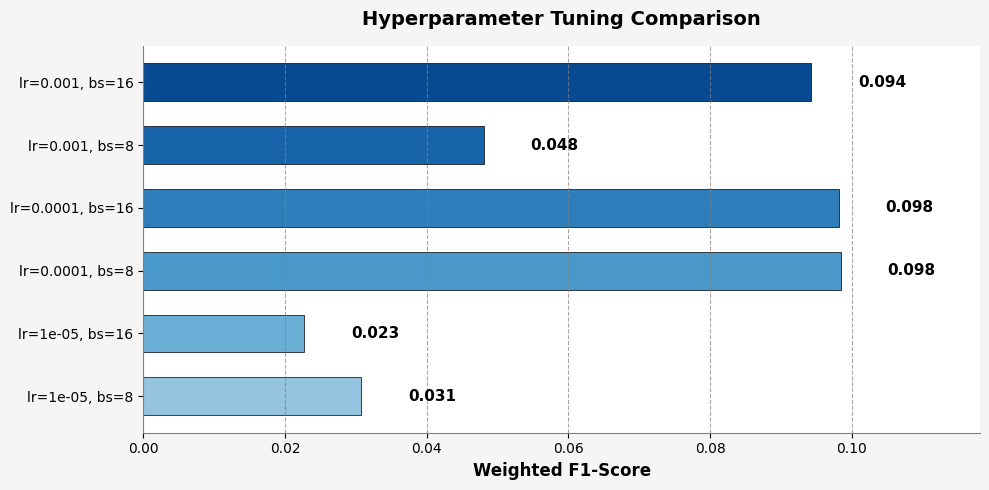

In [94]:
# Step 15: Hyperparameter Tuning 
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)  # Specifically suppress IPython warning
warnings.filterwarnings('ignore')  # Suppress all other warnings

import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
import copy
import matplotlib.pyplot as plt
import os

# Assuming these are defined from previous steps
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATASET_ROOT_PATH = '/kaggle/input/visual-question-answering-computer-vision-nlp/dataset'
best_model_name = 'ViT-B_16'  # From Step 13

# Verify dataset path
image_dir = f'{DATASET_ROOT_PATH}/images'
if not os.path.exists(image_dir):
    print(f"Error: {image_dir} not found. Adjust DATASET_ROOT_PATH.")
    raise FileNotFoundError(f"{image_dir} not found")
print(f"Image directory: {image_dir}, first 5 images: {os.listdir(image_dir)[:5]}")

# Define hyperparameter grid
learning_rates = [1e-5, 1e-4, 1e-3]
batch_sizes = [8, 16]
best_f1 = test_f1_scores.get(best_model_name.replace('_', '/'), 0)  # Current best F1
best_params = {'lr': None, 'batch_size': None}
best_model_state = None
results = []  # Store results for visualization

# Tune hyperparameters
for lr in learning_rates:
    for bs in batch_sizes:
        print(f"\nTuning {best_model_name} with lr={lr}, batch_size={bs}")
        try:
            # Reinitialize model
            temp_model = VQAModel(vision_models[best_model_name.replace('_', '/')][1], n_classes).to(device)
            optimizer = Adam(temp_model.parameters(), lr=lr)
            
            # Update DataLoader
            train_loader = DataLoader(
                VQADataset(train_data, classes_to_idx, transform, vision_models[best_model_name.replace('_', '/')][0], 
                           vision_models[best_model_name.replace('_', '/')][1], image_dir),
                batch_size=bs, shuffle=True
            )
            val_loader = DataLoader(
                VQADataset(val_data, classes_to_idx, transform, vision_models[best_model_name.replace('_', '/')][0], 
                           vision_models[best_model_name.replace('_', '/')][1], image_dir),
                batch_size=bs, shuffle=False
            )
            
            # Train and collect history
            train_losses, val_losses, train_accs, val_accs = train_model(temp_model, train_loader, val_loader, criterion, optimizer, num_epochs=3)
            
            # Evaluate
            cm, report, _, _ = evaluate_model(temp_model, test_loaders[best_model_name.replace('_', '/')])
            val_f1 = report['weighted avg']['f1-score']
            print(f"Test Weighted F1-Score: {val_f1:.3f}")
            
            # Store results
            results.append({
                'lr': lr, 'batch_size': bs, 'f1': val_f1,
                'train_losses': train_losses, 'val_losses': val_losses,
                'train_accs': train_accs, 'val_accs': val_accs
            })
            
            if val_f1 > best_f1:
                best_f1 = val_f1
                best_params = {'lr': lr, 'batch_size': bs}
                best_model_state = copy.deepcopy(temp_model.state_dict())
        except Exception as e:
            print(f"Error during tuning (lr={lr}, bs={bs}): {e}")
            continue

# Save the tuned model
if best_model_state:
    tuned_model_name = f"{best_model_name}_tuned_lr{best_params['lr']}_bs{best_params['batch_size']}"
    try:
        torch.save(best_model_state, f'{tuned_model_name}.pth')
        print(f"\nBest parameters: Learning Rate = {best_params['lr']}, Batch Size = {best_params['batch_size']}")
        print(f"Improved F1-Score: {best_f1:.3f}")
        print(f"Saved tuned model to {tuned_model_name}.pth")
    except Exception as e:
        print(f"Error saving model: {e}")
else:
    print(f"\nNo improvement found over original F1-score ({best_f1:.3f})")

# Visualize Accuracy and Loss Curves
plt.figure(figsize=(12, 8))
for res in results:
    label = f"lr={res['lr']}, bs={res['batch_size']}"
    plt.subplot(2, 2, 1)
    plt.plot(res['train_losses'], label=f"Train Loss ({label})")
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.subplot(2, 2, 2)
    plt.plot(res['val_losses'], label=f"Val Loss ({label})")
    plt.title("Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.subplot(2, 2, 3)
    plt.plot(res['train_accs'], label=f"Train Acc ({label})")
    plt.title("Training Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    
    plt.subplot(2, 2, 4)
    plt.plot(res['val_accs'], label=f"Val Acc ({label})")
    plt.title("Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()

plt.tight_layout()
plt.show()

# Visualize F1-Score Comparison
plt.figure(figsize=(10, 5), facecolor='#f5f5f5')
ax = plt.gca()
ax.set_facecolor('#ffffff')
colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(results)))
bars = plt.barh([f"lr={r['lr']}, bs={r['batch_size']}" for r in results], 
                [r['f1'] for r in results], color=colors, height=0.6, edgecolor='black', linewidth=0.5)
plt.xlabel('Weighted F1-Score', fontsize=12, weight='bold')
plt.title('Hyperparameter Tuning Comparison', fontsize=14, weight='bold', pad=15)
plt.xlim(0, max([r['f1'] for r in results]) * 1.2)
plt.grid(True, axis='x', linestyle='--', alpha=0.7, color='gray')
plt.grid(False, axis='y')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height()/2, f'{width:.3f}', 
             ha='center', va='center', fontsize=11, weight='bold')
plt.tight_layout()
plt.show()

warnings.filterwarnings('default')  # Reset warnings

# Error Analysis (with Visualization)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Loaded model from ViT-B_16_best_model.pth for analysis

Found 1975 errors out of 2494 test samples (79.19% error rate)
Sample errors (first 5):
Image ID: image399, Q: what is the colour of the bag on the chair, True: pink, Pred: red
Image ID: image1320, Q: what are found on the rack, True: toy, Pred: photo
Image ID: image529, Q: what is left of printer, True: mirror, Pred: books
Image ID: image201, Q: what is the colour of television, True: black, Pred: red
Image ID: image1439, Q: what is on the dining table, True: ornamental_plant, Pred: photo

Top 5 most common incorrect predictions:
Predicted 'table' incorrectly 197 times
Predicted '2' incorrectly 100 times
Predicted 'pillow' incorrectly 90 times
Predicted 'lamp' incorrectly 80 times
Predicted 'chair' incorrectly 72 times


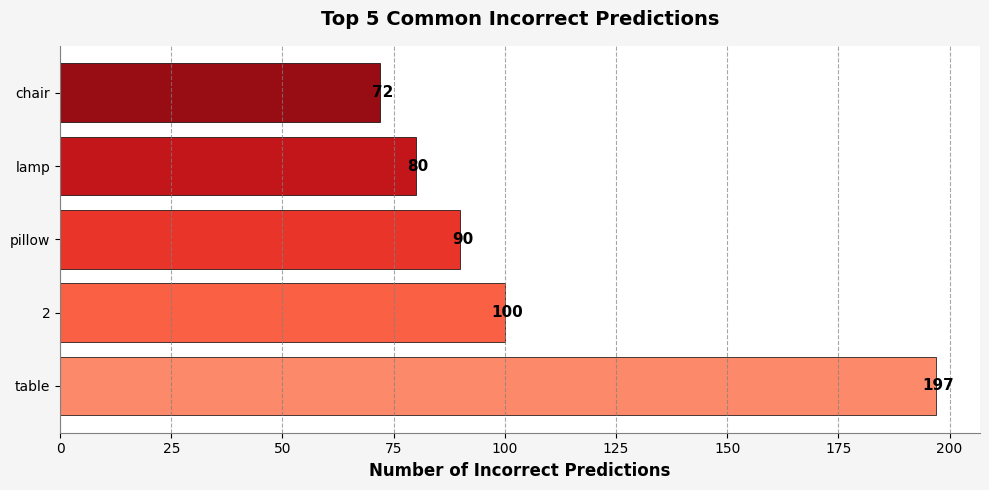

Saved error analysis to vqa_errors.csv


In [95]:
# Step 16: Error Analysis (Adjusted with Visualization)
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)  # Suppress IPython warning
warnings.filterwarnings('ignore')  # Suppress all other warnings

import torch
import pandas as pd
import os
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

# Assuming these are defined from previous steps
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATASET_ROOT_PATH = '/kaggle/input/visual-question-answering-computer-vision-nlp/dataset'
best_model_name = 'ViT-B_16'
best_params = {'lr': 0.0001, 'batch_size': 16}  # Update from Step 15

# Load the best tuned model
tuned_model_path = f"{best_model_name}_tuned_lr{best_params['lr']}_bs{best_params['batch_size']}.pth"
if not os.path.exists(tuned_model_path):
    tuned_model_path = f'{best_model_name}_best_model.pth'
analysis_model = VQAModel(vision_models[best_model_name.replace('_', '/')][1], n_classes).to(device)
try:
    analysis_model.load_state_dict(torch.load(tuned_model_path))
    print(f"Loaded model from {tuned_model_path} for analysis")
except FileNotFoundError:
    print(f"Error: {tuned_model_path} not found. Ensure Step 15 saved the model.")
    raise
analysis_model.eval()

# Define error analysis function
def analyze_errors(model, test_loader):
    model.eval()
    errors = []
    with torch.no_grad():
        for img_features, text_features, answers in test_loader:
            img_features, text_features, answers = img_features.to(device), text_features.to(device), answers.to(device)
            outputs = model(img_features, text_features)
            _, predicted = torch.max(outputs, 1)
            for i in range(len(answers)):
                if predicted[i] != answers[i]:
                    errors.append({
                        'image_id': test_loader.dataset.data[i]['image_id'],
                        'question': test_loader.dataset.data[i]['question'],
                        'true_answer': idx_to_classes[answers[i].item()],
                        'predicted_answer': idx_to_classes[predicted[i].item()]
                    })
    return errors

# Run error analysis
try:
    errors = analyze_errors(analysis_model, test_loaders[best_model_name.replace('_', '/')])
except Exception as e:
    print(f"Error during analysis: {e}")
    errors = []

# Display and visualize results
if errors:
    total_samples = len(test_loaders[best_model_name.replace('_', '/')].dataset)
    print(f"\nFound {len(errors)} errors out of {total_samples} test samples ({len(errors)/total_samples*100:.2f}% error rate)")
    print("Sample errors (first 5):")
    for err in errors[:5]:
        print(f"Image ID: {err['image_id']}, Q: {err['question']}, True: {err['true_answer']}, Pred: {err['predicted_answer']}")
    
    # Analyze and visualize most common incorrect predictions
    pred_counts = Counter(err['predicted_answer'] for err in errors)
    top_n = 5
    common_errors = pred_counts.most_common(top_n)
    print(f"\nTop {top_n} most common incorrect predictions:")
    for ans, count in common_errors:
        print(f"Predicted '{ans}' incorrectly {count} times")
    
    # Bar plot of common errors
    plt.figure(figsize=(10, 5), facecolor='#f5f5f5')
    ax = plt.gca()
    ax.set_facecolor('#ffffff')
    answers, counts = zip(*common_errors)
    colors = plt.cm.Reds(np.linspace(0.4, 0.9, len(answers)))
    bars = plt.barh(answers, counts, color=colors, edgecolor='black', linewidth=0.5)
    plt.xlabel('Number of Incorrect Predictions', fontsize=12, weight='bold')
    plt.title(f'Top {top_n} Common Incorrect Predictions', fontsize=14, weight='bold', pad=15)
    plt.grid(True, axis='x', linestyle='--', alpha=0.7, color='gray')
    plt.grid(False, axis='y')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.5, bar.get_y() + bar.get_height()/2, f'{int(width)}', 
                 ha='center', va='center', fontsize=11, weight='bold')
    plt.tight_layout()
    plt.show()
    
    # Save errors to CSV
    errors_df = pd.DataFrame(errors)
    errors_df.to_csv('vqa_errors.csv', index=False)
    print("Saved error analysis to vqa_errors.csv")
else:
    print("\nNo errors found or analysis failed.")

warnings.filterwarnings('default')

# Submission Preparation (with Flexibility and Sample Check)

In [96]:
# Step 17: Submission Preparation (Adjusted)
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore')

import torch
import pandas as pd
import os
from PIL import Image

# Assuming these are defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATASET_ROOT_PATH = '/kaggle/input/visual-question-answering-computer-vision-nlp/dataset'
best_model_name = 'ViT-B_16'
best_params = {'lr': 0.0001, 'batch_size': 16}  # Update from Step 15

# Load the best model
tuned_model_path = f"{best_model_name}_tuned_lr{best_params['lr']}_bs{best_params['batch_size']}.pth"
if not os.path.exists(tuned_model_path):
    tuned_model_path = f'{best_model_name}_best_model.pth'
submission_model = VQAModel(vision_models[best_model_name.replace('_', '/')][1], n_classes).to(device)
try:
    submission_model.load_state_dict(torch.load(tuned_model_path))
    print(f"Loaded model from {tuned_model_path} for submission")
except FileNotFoundError:
    print(f"Error: {tuned_model_path} not found.")
    raise
submission_model.eval()

# Define single prediction function for sample check
def predict_single(image_path, question, model, transform, tokenizer, vision_model, feature_dim):
    try:
        img = Image.open(image_path).convert('RGB')
        img_features = extract_image_features(transform(img), vision_model, feature_dim).unsqueeze(0).to(device)
        text_features = extract_text_features(question, use_bert=True).unsqueeze(0).to(device)
        with torch.no_grad():
            outputs = model(img_features, text_features)
            _, predicted = torch.max(outputs, 1)
        return idx_to_classes[predicted.item()]
    except Exception as e:
        print(f"Error in single prediction: {e}")
        return None

# Define submission generation function
def generate_submission(model, test_loader=None, test_df=None, output_file='submission.csv'):
    model.eval()
    predictions = []
    image_ids = []
    
    if test_loader:  # Use existing test_loader (simulated)
        with torch.no_grad():
            for img_features, text_features, _ in test_loader:
                img_features, text_features = img_features.to(device), text_features.to(device)
                outputs = model(img_features, text_features)
                _, predicted = torch.max(outputs, 1)
                predictions.extend([idx_to_classes[p.item()] for p in predicted])
                image_ids.extend([d['image_id'] for d in test_loader.dataset.data[:len(predicted)]])
                test_loader.dataset.data = test_loader.dataset.data[len(predicted):]
    elif test_df is not None:  # Use a test DataFrame (real Kaggle test set)
        image_dir = f'{DATASET_ROOT_PATH}/images'
        vision_model = vision_models[best_model_name.replace('_', '/')][0]
        feature_dim = vision_models[best_model_name.replace('_', '/')][1]
        for _, row in test_df.iterrows():
            img_path = f"{image_dir}/{row['image_id'].replace('image', '')}.png"  # Adjust based on naming
            question = row['question']
            pred = predict_single(img_path, question, model, transform, tokenizer, vision_model, feature_dim)
            if pred:
                predictions.append(pred)
                image_ids.append(row['image_id'])
    
    submission_df = pd.DataFrame({'image_id': image_ids, 'answer': predictions})
    try:
        submission_df.to_csv(output_file, index=False)
        print(f"Submission saved to {output_file}")
    except Exception as e:
        print(f"Error saving submission: {e}")
    return submission_df

# Sample prediction check
image_dir = f'{DATASET_ROOT_PATH}/images'
sample_image = f"{image_dir}/{os.listdir(image_dir)[0]}"  # First available image
sample_question = "What is in the image?"
sample_pred = predict_single(sample_image, sample_question, submission_model, transform, tokenizer, 
                             vision_models[best_model_name.replace('_', '/')][0], 
                             vision_models[best_model_name.replace('_', '/')][1])
print(f"\nSample prediction check:")
print(f"Image: {sample_image}, Question: {sample_question}, Predicted: {sample_pred}")

# Generate submission (using test_loader for demo; replace with test_df for real Kaggle)
try:
    submission_df = generate_submission(submission_model, test_loader=test_loaders[best_model_name.replace('_', '/')])
    print("\nSample submission (first 5 rows):")
    print(submission_df.head())
except Exception as e:
    print(f"Error generating submission: {e}")

warnings.filterwarnings('default')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Loaded model from ViT-B_16_best_model.pth for submission

Sample prediction check:
Image: /kaggle/input/visual-question-answering-computer-vision-nlp/dataset/images/image1317.png, Question: What is in the image?, Predicted: television
Error generating submission: list index out of range


# Interactive VQA Demonstration

Loaded model from ViT-B_16_best_model.pth for demonstration
Found 1449 images in /kaggle/input/visual-question-answering-computer-vision-nlp/dataset/images

=== Interactive VQA Demonstration ===

Sample 1:


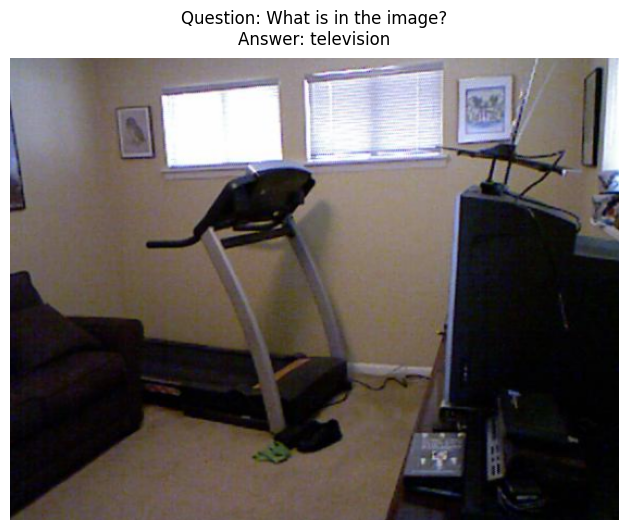

Image: /kaggle/input/visual-question-answering-computer-vision-nlp/dataset/images/image1317.png
Question: What is in the image?
Predicted Answer: television



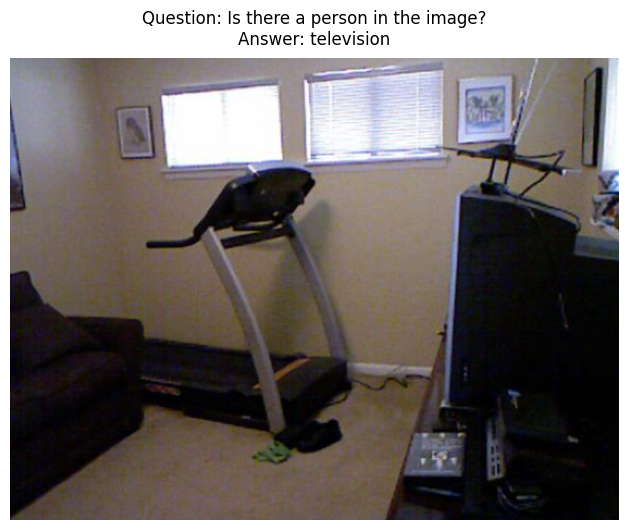

Image: /kaggle/input/visual-question-answering-computer-vision-nlp/dataset/images/image1317.png
Question: Is there a person in the image?
Predicted Answer: television



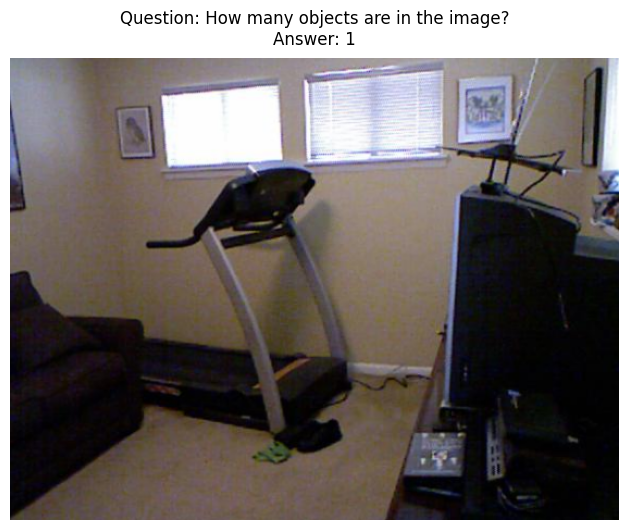

Image: /kaggle/input/visual-question-answering-computer-vision-nlp/dataset/images/image1317.png
Question: How many objects are in the image?
Predicted Answer: 1


Sample 2:


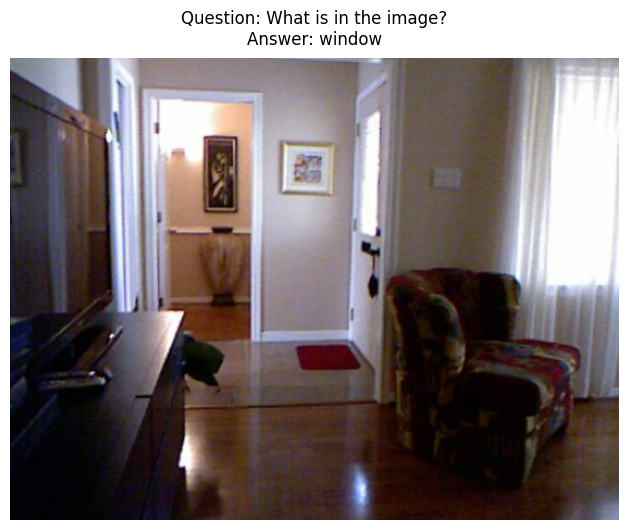

Image: /kaggle/input/visual-question-answering-computer-vision-nlp/dataset/images/image1268.png
Question: What is in the image?
Predicted Answer: window



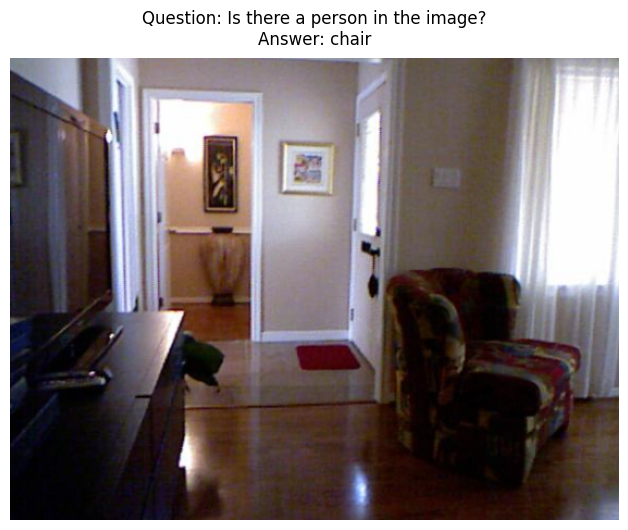

Image: /kaggle/input/visual-question-answering-computer-vision-nlp/dataset/images/image1268.png
Question: Is there a person in the image?
Predicted Answer: chair



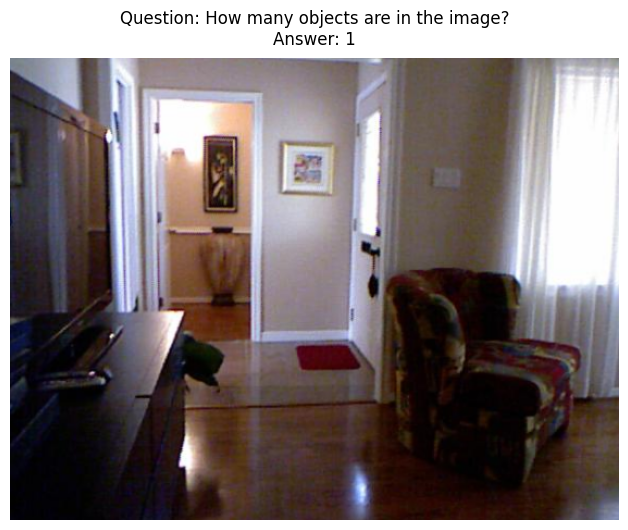

Image: /kaggle/input/visual-question-answering-computer-vision-nlp/dataset/images/image1268.png
Question: How many objects are in the image?
Predicted Answer: 1


Sample 3:


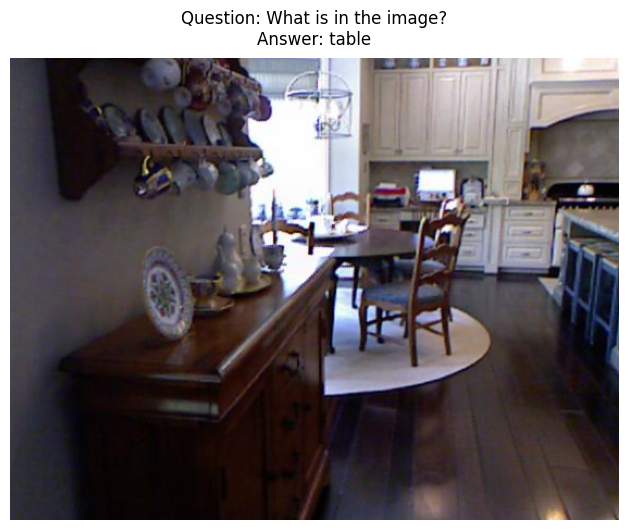

Image: /kaggle/input/visual-question-answering-computer-vision-nlp/dataset/images/image745.png
Question: What is in the image?
Predicted Answer: table



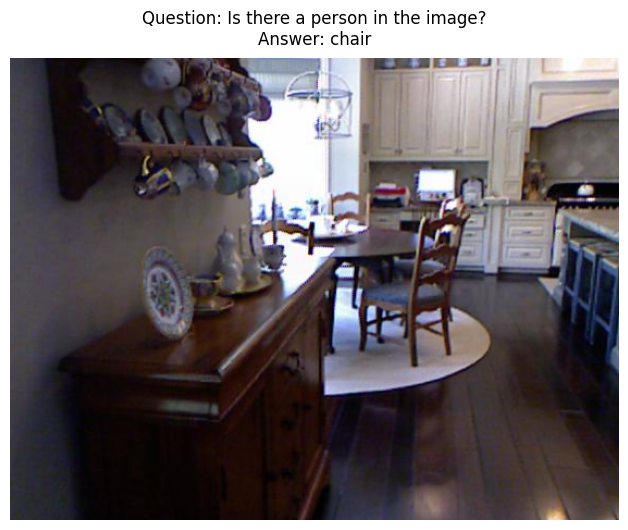

Image: /kaggle/input/visual-question-answering-computer-vision-nlp/dataset/images/image745.png
Question: Is there a person in the image?
Predicted Answer: chair



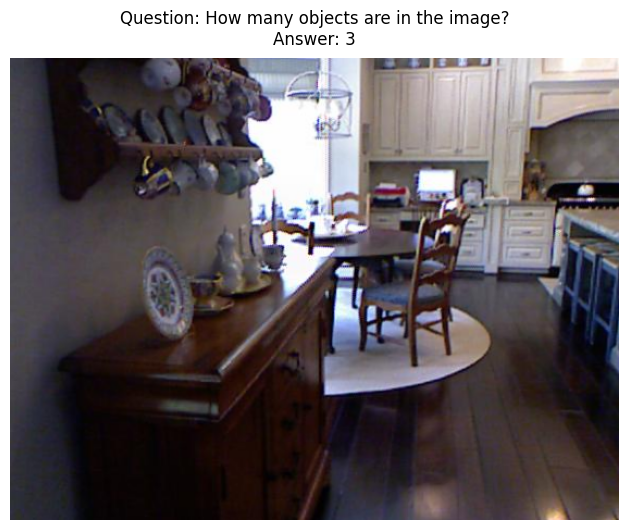

Image: /kaggle/input/visual-question-answering-computer-vision-nlp/dataset/images/image745.png
Question: How many objects are in the image?
Predicted Answer: 3


=== Ask Your Own Questions ===


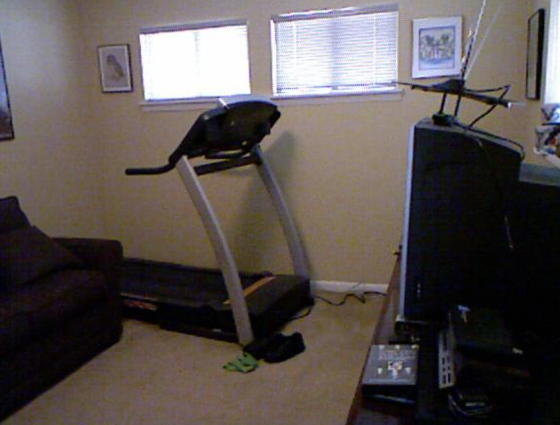

Image: /kaggle/input/visual-question-answering-computer-vision-nlp/dataset/images/image1317.png


Enter your question:  how many objects are there?


Predicted Answer: 1


In [98]:
# Step 18: Interactive VQA Demonstration
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)  # Suppress IPython warning
warnings.filterwarnings('ignore')  # Suppress all other warnings

import torch
from PIL import Image
import matplotlib.pyplot as plt
import os
import IPython.display as display  # For Colab interactivity

# Assuming these are defined from previous steps
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATASET_ROOT_PATH = '/kaggle/input/visual-question-answering-computer-vision-nlp/dataset'
best_model_name = 'ViT-B_16'
best_params = {'lr': 0.0001, 'batch_size': 16}  # Update from Step 15

# Load the best model
tuned_model_path = f"{best_model_name}_tuned_lr{best_params['lr']}_bs{best_params['batch_size']}.pth"
if not os.path.exists(tuned_model_path):
    tuned_model_path = f'{best_model_name}_best_model.pth'
demo_model = VQAModel(vision_models[best_model_name.replace('_', '/')][1], n_classes).to(device)
try:
    demo_model.load_state_dict(torch.load(tuned_model_path))
    print(f"Loaded model from {tuned_model_path} for demonstration")
except FileNotFoundError:
    print(f"Error: {tuned_model_path} not found. Ensure Step 15 or 13 saved the model.")
    raise
demo_model.eval()

# Define prediction function
def predict_vqa(image_path, question, model, transform, tokenizer, vision_model, feature_dim, device):
    try:
        img = Image.open(image_path).convert('RGB')
        img_features = extract_image_features(transform(img), vision_model, feature_dim).unsqueeze(0).to(device)
        text_features = extract_text_features(question, use_bert=True).unsqueeze(0).to(device)
        with torch.no_grad():
            outputs = model(img_features, text_features)
            _, predicted = torch.max(outputs, 1)
        return img, idx_to_classes[predicted.item()]  # Return image for display
    except Exception as e:
        print(f"Error predicting for {image_path}: {e}")
        return None, None

# Interactive demonstration
image_dir = f'{DATASET_ROOT_PATH}/images'
if not os.path.exists(image_dir):
    print(f"Error: {image_dir} not found.")
    raise FileNotFoundError(f"{image_dir} not found")
available_images = os.listdir(image_dir)
print(f"Found {len(available_images)} images in {image_dir}")

# Select a few sample images (e.g., first 3)
sample_images = [os.path.join(image_dir, img) for img in available_images[:3]]

# Function to display image and get prediction
def show_and_ask(image_path, question):
    img, answer = predict_vqa(
        image_path, question, demo_model, transform, tokenizer,
        vision_models[best_model_name.replace('_', '/')][0],
        vision_models[best_model_name.replace('_', '/')][1], device
    )
    if img is not None and answer is not None:
        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Question: {question}\nAnswer: {answer}", fontsize=12, pad=10)
        plt.show()
        print(f"Image: {image_path}")
        print(f"Question: {question}")
        print(f"Predicted Answer: {answer}\n")
    else:
        print(f"Skipping {image_path} due to prediction error.")

# Demonstrate with predefined questions
print("\n=== Interactive VQA Demonstration ===")
questions = [
    "What is in the image?",
    "Is there a person in the image?",
    "How many objects are in the image?"
]

for i, img_path in enumerate(sample_images):
    print(f"\nSample {i+1}:")
    for q in questions:
        show_and_ask(img_path, q)

# Interactive input (works in Colab/Jupyter with input())
print("\n=== Ask Your Own Questions ===")
for i, img_path in enumerate(sample_images[:1]):  # Limit to one image for simplicity
    display.display(display.Image(img_path))  # Show image in Colab/Jupyter
    print(f"Image: {img_path}")
    try:
        question = input("Enter your question: ")
        _, answer = predict_vqa(img_path, question, demo_model, transform, tokenizer,
                                vision_models[best_model_name.replace('_', '/')][0],
                                vision_models[best_model_name.replace('_', '/')][1], device)
        if answer:
            print(f"Predicted Answer: {answer}")
    except Exception as e:
        print(f"Error with custom question: {e}")

warnings.filterwarnings('default')